Напишем простой классификатор биологического гендера спикера по мел спектрограмме.

#1. Подготовка данных

Установим и импортируем необходимые библиотеки:

In [1]:
#!pip3 install librosa
#!apt-get install -y ffmpeg
!pip install timit-utils

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp37-none-any.whl size=5887 sha256=7f820f3eadade4979e895e0939783c97aee106222726536ef693a25f03391987
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


In [2]:
pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4MB 25kB/s 
     |████████████████████████████████| 12.8MB 173kB/s 
     |████████████████████████████████| 7.6MB 7.1MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1+cu101 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101


In [3]:
from sklearn.model_selection import train_test_split
from itertools import chain
from tqdm import tqdm
from joblib import dump, load
import os

import matplotlib.pyplot as plt
import IPython # прослушивание аудио в ноутбуке
import numpy as np # отсюда возьмем Фурье
import librosa # множественные манипуляции с аудиофайлами 


%matplotlib inline

import timit_utils as tu
import timit_utils.audio_utils as au
import timit_utils.drawing_utils as du

import torch

from tqdm import tqdm
from PIL import Image
import PIL

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


from sklearn.metrics import accuracy_score
plt.style.use('fivethirtyeight')


Подсключим GPU:

In [4]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


Обозначим константы:

In [5]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру RESCALE_SIZExRESCALE_SIZE px
RESCALE_SIZE = 299
# работаем на видеокарте
if train_on_gpu:
  DEVICE = torch.device("cuda") 
else:
  DEVICE = torch.device("cpu")
SEED=42

Зафиксируем генераторы случайных чисел:

In [6]:
np.random.seed(SEED)

torch.manual_seed(SEED)

torch.cuda.manual_seed(SEED)

torch.backends.cudnn.deterministic = True

Скачаем данные:

In [10]:
!wget https://ndownloader.figshare.com/files/10256148

--2021-04-04 09:36:08--  https://ndownloader.figshare.com/files/10256148
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 108.128.230.190, 52.208.57.228, 34.250.216.184, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|108.128.230.190|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/10256148/TIMIT.zip [following]
--2021-04-04 09:36:08--  https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/10256148/TIMIT.zip
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.101.203
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.101.203|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 440207227 (420M) [binary/octet-stream]
Saving to: ‘10256148’

10256148            100%[===================>] 419.81M  20.3MB/s    in 22s     

2021-04-04 09:36:31 (19.2 MB/s) - ‘10256148’ saved [440207227/440207227]



In [11]:
!unzip -q 10256148

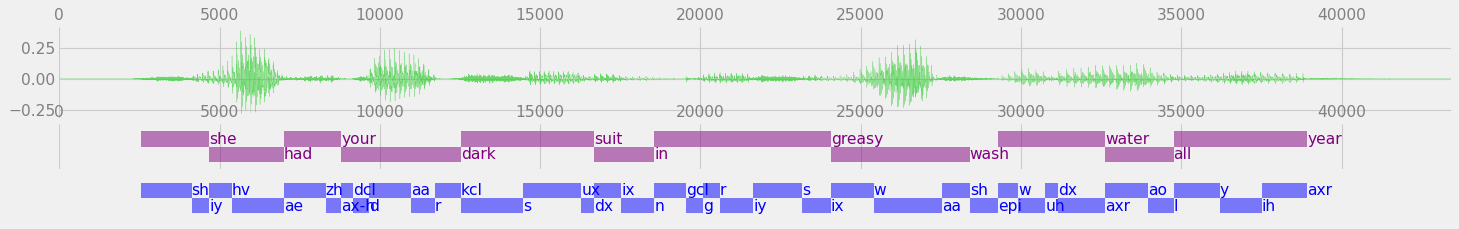

In [12]:
DATA_PATH = 'data/lisa/data/timit/raw/TIMIT'
corpus = tu.Corpus(DATA_PATH)
sentence = corpus.train.sentences_by_phone_df('aa').sentence[0]
du.DrawVerticalPanels([du.AudioPanel(sentence.raw_audio, show_x_axis=True),
                       du.WordsPanel(sentence.words_df, sentence.raw_audio.shape[0], show_x_axis=True),
                       du.PhonesPanel(sentence.phones_df, sentence.raw_audio.shape[0])
                      ])

Будем находить информацию про пол говорящего:

In [13]:
class Speaker:

  def __init__(self, data_path):
    self.doc_file_path = os.path.join(data_path, 'DOC','SPKRINFO.TXT')
    with open(self.doc_file_path) as f:
      self.id_sex_dict = dict([(tmp.split(' ')[0], tmp.split(' ')[2]) for tmp in f.readlines()[39:]])

  def return_sex(self, id):
    return self.id_sex_dict[id]

Speakers_info = Speaker(DATA_PATH)

Протестируем на паре примеров:

In [14]:
person_1 = corpus.train.person_by_index(100)
Speakers_info.return_sex(person_1.name)

'M'

In [15]:
person_2 = corpus.train.person_by_index(300)
Speakers_info.return_sex(person_2.name)

'F'

In [16]:
person_1.print_all()


Person DPS0 M data/lisa/data/timit/raw/TIMIT/TRAIN/DR2/MDPS0
  Sentence SA1 data/lisa/data/timit/raw/TIMIT/TRAIN/DR2/MDPS0
  Sentence SA2 data/lisa/data/timit/raw/TIMIT/TRAIN/DR2/MDPS0
  Sentence SI1651 data/lisa/data/timit/raw/TIMIT/TRAIN/DR2/MDPS0
  Sentence SI1979 data/lisa/data/timit/raw/TIMIT/TRAIN/DR2/MDPS0
  Sentence SI719 data/lisa/data/timit/raw/TIMIT/TRAIN/DR2/MDPS0
  Sentence SX179 data/lisa/data/timit/raw/TIMIT/TRAIN/DR2/MDPS0
  Sentence SX269 data/lisa/data/timit/raw/TIMIT/TRAIN/DR2/MDPS0
  Sentence SX359 data/lisa/data/timit/raw/TIMIT/TRAIN/DR2/MDPS0
  Sentence SX449 data/lisa/data/timit/raw/TIMIT/TRAIN/DR2/MDPS0
  Sentence SX89 data/lisa/data/timit/raw/TIMIT/TRAIN/DR2/MDPS0


In [17]:
person_2.print_all()

Person PAD0 F data/lisa/data/timit/raw/TIMIT/TRAIN/DR6/FPAD0
  Sentence SA1 data/lisa/data/timit/raw/TIMIT/TRAIN/DR6/FPAD0
  Sentence SA2 data/lisa/data/timit/raw/TIMIT/TRAIN/DR6/FPAD0
  Sentence SI1346 data/lisa/data/timit/raw/TIMIT/TRAIN/DR6/FPAD0
  Sentence SI1976 data/lisa/data/timit/raw/TIMIT/TRAIN/DR6/FPAD0
  Sentence SI716 data/lisa/data/timit/raw/TIMIT/TRAIN/DR6/FPAD0
  Sentence SX176 data/lisa/data/timit/raw/TIMIT/TRAIN/DR6/FPAD0
  Sentence SX266 data/lisa/data/timit/raw/TIMIT/TRAIN/DR6/FPAD0
  Sentence SX356 data/lisa/data/timit/raw/TIMIT/TRAIN/DR6/FPAD0
  Sentence SX446 data/lisa/data/timit/raw/TIMIT/TRAIN/DR6/FPAD0
  Sentence SX86 data/lisa/data/timit/raw/TIMIT/TRAIN/DR6/FPAD0


Функция, отображающая визуально звуковой сигнал.
Файл *.wav -- набор амплитуд, отсчитываемых за определенные промежутки времени. Sample rate  -- число отсчитываемых амплитуд в секунду, параметр качества записи.

In [18]:
def show_signal(amplitudes, sample_rate):
  print(f"{len(amplitudes)} points, {len(amplitudes) / sample_rate} sec, sr {sample_rate}")
  plt.figure(figsize=[15, 4])
  plt.title('')
  plt.plot(amplitudes[20000:25000],linewidth=1.5)

Посмотрим на примерах:

72960 points, 3.308843537414966 sec, sr 22050


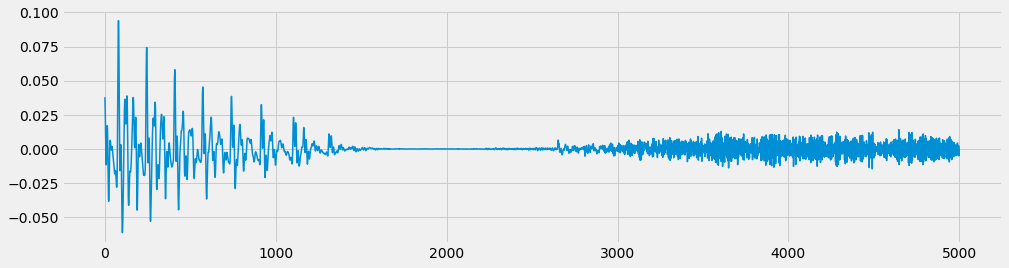

In [19]:
amplitudes_1, sample_rate_1 = librosa.load("data/lisa/data/timit/raw/TIMIT/TRAIN/DR2/MDPS0/SA1.WAV")
show_signal(amplitudes_1, sample_rate_1)

85378 points, 3.872018140589569 sec, sr 22050


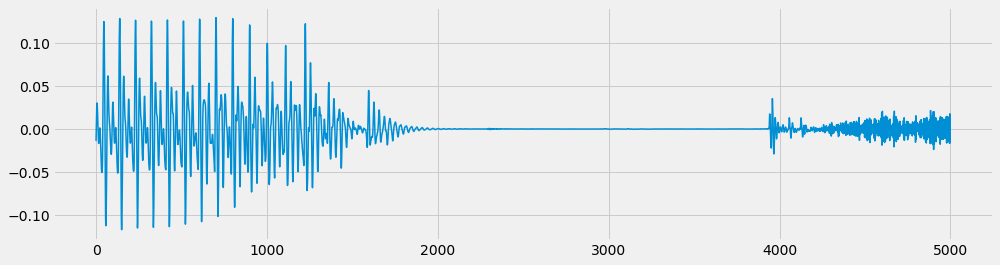

In [20]:
amplitudes_2, sample_rate_2 = librosa.load("data/lisa/data/timit/raw/TIMIT/TRAIN/DR6/FPAD0/SA1.WAV")
show_signal(amplitudes_2, sample_rate_2)

В двух секундах 60000 точек! Работать неудобно, надо конвертировать в формат, с которым умеем работать (в изображение). Используем **быстрое преобразование Фурье** чтобы понять, какие же именно компоненты преобладают в некоторый момент времени. 

Не забудем, что перед преобразование Фурье мы используем к фреймам по отдельности и потом склеиваем все в единую картину. Также следует помнить, что если использовать просто спектрограмму без перехода в мел-пространство, то мы можем сломать нашу будущую сетку слишком большими значениями. 

**Алгоритм построения мел-спектрограммы по набору частот:**
1. Разделяем вход на пересекающиеся фреймы
2. Применяем к каждому преобразование Фурье
3. Переводим полученную спектрограмму в мел-пространство

Напишем соответствующие функции:

In [21]:
def slice_into_frames(amplitudes, window_length, hop_length):
    return librosa.core.spectrum.util.frame(
        np.pad(amplitudes, int(window_length // 2), mode='reflect'),
        frame_length=window_length, hop_length=hop_length)
    # выход: [window_length, num_windows]

In [22]:
def get_STFT(amplitudes, window_length, hop_length):
    """ Compute short-time Fourier Transform """
    # разбиваем амплитуды на пересекающиеся фреймы [window_length, num_frames]
    frames = slice_into_frames(amplitudes, window_length, hop_length)
    
    # получаем веса для Фурье, float[window_length]
    fft_weights = librosa.core.spectrum.get_window('hann', window_length, fftbins=True)
    
    # применяем преобразование Фурье
    stft = np.fft.rfft(frames * fft_weights[:, None], axis=0)
    return stft

In [23]:
def get_melspectrogram(amplitudes, sample_rate=22050, n_mels=128,
                       window_length=2048, hop_length=512, fmin=50, fmax=16500):
    """
    Implement mel-spectrogram as described above.
    :param amplitudes: float [num_amplitudes]
    :param sample rate: число отсчетов каждую секунду
    :param n_mels: число каналов спектрограммы
    :param window_length: параметр размера окна для Фурье
    :param hop_length: размер пересечения 
    :param f_min: мин частота
    :param f_max: макс частота
    :returns: мел-scaled спектрограмма [n_mels, duration]
    """
    # Шаг 1
    stft = get_STFT(amplitudes, window_length, hop_length)
    assert stft.shape == (window_length // 2 + 1, len(amplitudes) // 512 + 1)
    
    # Шаг 2
    spectrogram = np.abs(stft ** 2)
    
    # Шаг 3
    mel_basis = librosa.filters.mel(sample_rate, n_fft=window_length,
                                    n_mels=n_mels, fmin=fmin, fmax=fmax)
    # ^-- matrix [n_mels, window_length / 2 + 1]
    
    mel_spectrogram = np.dot(mel_basis, spectrogram)
    assert mel_spectrogram.shape == (n_mels, len(amplitudes) // 512 + 1)
    
    return mel_spectrogram

Посмотрим на мел-спектрограммы на примерах:

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


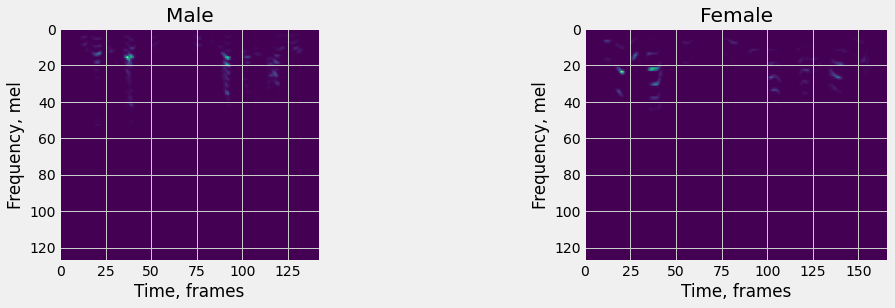

In [43]:
plt.figure(figsize=[16, 4])
plt.subplot(1, 2, 1)
plt.title("Male"); plt.xlabel("Time, frames"); plt.ylabel("Frequency, mel")
plt.imshow(get_melspectrogram(amplitudes_1))

plt.subplot(1, 2, 2)
plt.title("Female"); plt.xlabel("Time, frames"); plt.ylabel("Frequency, mel")
plt.imshow(get_melspectrogram(amplitudes_2));

Другой способ получить мел-спектрограмму:

In [25]:
ref1 = librosa.feature.melspectrogram(amplitudes_1, sr=sample_rate_1, n_mels=128, fmin=50, fmax=16500)
assert np.allclose(get_melspectrogram(amplitudes_1), ref1, rtol=1e-4, atol=1e-4)

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


Посмотрим на среднеквадратичную ошибку между двумя способами. Она ничтожно мала:

In [26]:
((ref1-get_melspectrogram(amplitudes_1)) **2).mean()

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


7.343438004463203e-17

Предобработка семпла:

In [27]:
def preprocess_sample(amplitudes, gender, sr=16000, max_length=150):
    spectrogram = get_melspectrogram(amplitudes, sample_rate=sr)[:, :max_length]
    
    plt.imsave('/content/data/1.gif', spectrogram)
    image = Image.open('/content/data/1.gif').convert('RGB').resize((RESCALE_SIZE, RESCALE_SIZE))
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    #image = transform(image)
    
    target = 0 if gender == 'F' else 1
    
    return np.array(image).transpose([2, 0, 1]), np.array(target)

Создадим тестсет и трейнсет из данных для TIMIT:

In [28]:
def create_dataset(mode='train'):
  assert mode in ['train','test']
  if mode == 'train':
    people = [corpus.train.person_by_index(i) for i in range(300)]
  if mode == 'test':
    people = [corpus.test.person_by_index(i) for i in range(100)]
  spectrograms_and_targets = []
  for person in tqdm(people): 
    target = Speakers_info.return_sex(person.name)
    for i in range(len(person.sentences)):
      spectrograms_and_targets.append(preprocess_sample(person.sentence_by_index(i).raw_audio, target))
  return spectrograms_and_targets

In [29]:
trainset = create_dataset('train')

  0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "
100%|██████████| 300/300 [00:50<00:00,  5.93it/s]


Разобьем на тренировочную и валидационную выборки:

In [30]:
trainset_train, trainset_val = train_test_split(trainset, test_size = 0.2, random_state=SEED)

In [31]:
testset = create_dataset('test')

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "
100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


# Обучение модели

Будем использовать pytorch. Импортируем модель vgg16:

In [33]:
from torchvision.models.vgg import vgg16

VGGModel=vgg16(pretrained=True)
num_features = VGGModel.classifier[6].in_features
features = list(VGGModel.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, 2)]) # Add our layer with 2 outputs
VGGModel.classifier = nn.Sequential(*features) # Replace the model classifier
VGGModel = VGGModel.to(DEVICE)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


Напишем ряд функций для обучения модели и предсказаний:

In [34]:
def fit_epoch(model, train_loader, criterion, optimizer):
    #Обнуляем переменные
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    
  
    for inputs, labels in train_loader:
        #Отправляем входные данные на GPU
        inputs = inputs/255
        inputs = (inputs).to(DEVICE)
        labels = labels.to(DEVICE)
        #Обнуляем градиенты оптимайзера
        optimizer.zero_grad()

        #Проссчитываем выходные данные с помощью модели
        outputs = model(inputs)
        #Считаем loss
        loss = criterion(outputs, labels)
        #Делаем градиентный спуск
        loss.backward()
        optimizer.step()
        #Выбираем индексы максимальных значений на выходах (наше предсказание)
        preds = torch.argmax(outputs, 1)
        #Считаем текущий loss для всех входов
        running_loss += loss.item() * inputs.size(0)
        #Считаем количество правильных ответов
        running_corrects += torch.sum(preds == labels.data)
        #Прибавляем кол-во входов
        processed_data += inputs.size(0)
    #Считаем  train loss, train accuracy         
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    #Возвращаем значения train loss, train accuracy
    return train_loss, train_acc

In [35]:
def eval_epoch(model, val_loader, criterion):
    #Применяем метод eval() модели
    model.eval()
    #Зануляем переменные
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        #Отправляем входные данные на GPU
        inputs = inputs/255
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            #Проссчитываем выходные данные с помощью модели
            outputs = model(inputs)
            #Считаем loss
            loss = criterion(outputs, labels)
            #Выбираем индексы максимальных значений на выходах (наше предсказание)
            preds = torch.argmax(outputs, 1)
        #Считаем текущий loss для всех входов
        running_loss += loss.item() * inputs.size(0)
        #Считаем количество правильных ответов
        running_corrects += torch.sum(preds == labels.data)
        #Прибавляем кол-во входов
        processed_size += inputs.size(0)
    #Считаем  val loss, val accuracy 
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    #Возвращаем значения val loss, val accuracy
    return val_loss, val_acc

In [36]:
def train(train_files, val_files, model, epochs, batch_size):
    #Загружаем батчи DataLoader-ом
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)
    
    history = []
    
    #Формируем формат логов
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
      params_to_update = []
      #Обновляем все "незамороженные" параметры модели
      for param in model.parameters():
        if param.requires_grad == True:
          params_to_update.append(param)
      #Задаем оптимайзер Adam
      opt = torch.optim.Adam(params_to_update, lr=0.0001)
      #Ставим Scheduler 
      scheduler=torch.optim.lr_scheduler.StepLR(opt,7,gamma=0.3)
      #Применяем кроссэнтропию
      criterion = nn.CrossEntropyLoss()

      # По каждой эпохе
      for epoch in range(epochs):
        #Применяем функцию fit_epoch
        train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
        #Печатаем train_loss
        print("loss", train_loss)
        #Делаем "шаг" для scheduler
        scheduler.step(train_loss)
        #Применяем функцию eval_epoch
        val_loss, val_acc = eval_epoch(model, val_loader, criterion)
        #Добавляем данные в history
        history.append((train_loss, train_acc, val_loss, val_acc))
        dump(model, 'model.joblib')
        #torch.save(model.state_dict(), "weights.pth").to(CPU)
       
        #Выводим логи
        pbar_outer.update(1)
        tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                       v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
    #Возвращаем значение history       
    return history

In [37]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        #Для всех входных данных в даталоаделе
        for inputs,_ in test_loader:
            #Отправляем входные данные на GPU
            inputs=inputs/255
            inputs = inputs.to(DEVICE)
            #Применяем метод eval модели
            model.eval()
            #Просчитываем выходные данные
            outputs = model(inputs).cpu()
            #Добавляем данные в logits
            logits.append(outputs)
    #Применяем Softmax        
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Запустим модель тренироваться:

In [38]:
history = train(trainset_train, trainset_val, model=VGGModel, epochs=7, batch_size=16)

epoch:   0%|          | 0/7 [00:00<?, ?it/s]

loss 0.1658863508224143


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
epoch:  14%|█▍        | 1/7 [01:57<11:42, 117.01s/it]


Epoch 001 train_loss: 0.1659     val_loss 0.1520 train_acc 0.9437 val_acc 0.9283
loss 0.09799907287602158


epoch:  29%|██▊       | 2/7 [03:55<09:47, 117.58s/it]


Epoch 002 train_loss: 0.0980     val_loss 0.0655 train_acc 0.9671 val_acc 0.9783
loss 0.05753451460997288


epoch:  43%|████▎     | 3/7 [05:55<07:52, 118.09s/it]


Epoch 003 train_loss: 0.0575     val_loss 0.1223 train_acc 0.9800 val_acc 0.9633
loss 0.03850861668812191


epoch:  57%|█████▋    | 4/7 [07:54<05:54, 118.32s/it]


Epoch 004 train_loss: 0.0385     val_loss 0.0652 train_acc 0.9892 val_acc 0.9767
loss 0.020739483498521737


epoch:  71%|███████▏  | 5/7 [09:53<03:57, 118.56s/it]


Epoch 005 train_loss: 0.0207     val_loss 0.0657 train_acc 0.9908 val_acc 0.9817
loss 0.009629543242159776


epoch:  86%|████████▌ | 6/7 [11:52<01:58, 118.69s/it]


Epoch 006 train_loss: 0.0096     val_loss 0.2470 train_acc 0.9979 val_acc 0.9833
loss 0.11016358278584307


epoch: 100%|██████████| 7/7 [13:50<00:00, 118.62s/it]


Epoch 007 train_loss: 0.1102     val_loss 0.1159 train_acc 0.9692 val_acc 0.9683


In [39]:
loss, acc, val_loss, val_acc = zip(*history)

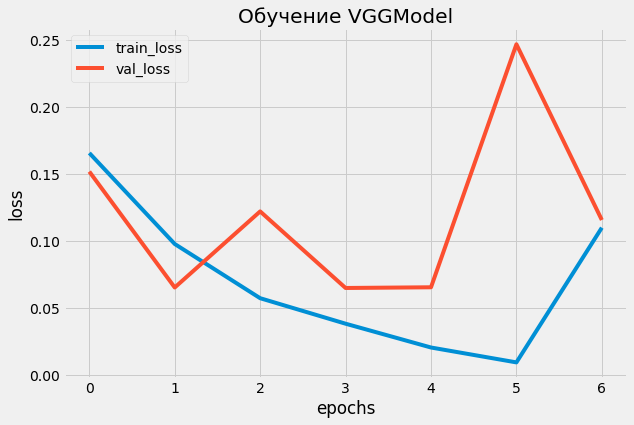

In [40]:
plt.figure(figsize=(9, 6))
plt.title('Обучение VGGModel')
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

#Тестирование модели

Протестируем модель на тестовой выборке и посмотрим на accuracy_score:

In [41]:
test_loader = DataLoader(testset, shuffle=False, batch_size=16)
probs = predict(VGGModel, test_loader)
preds = np.argmax(probs, axis=1)
labels = []
for i in range(len(testset)):
  labels.append(testset[i][1])
accuracy = accuracy_score(labels, preds)
print('test accuracy score = {:.4f}'.format(accuracy))

test accuracy score = 0.9330


Посмотрим, как определяется гендер спикера из произвольного файла:

In [44]:
amplitudes, sample_rate = librosa.load('/content/hello.mp3')
sample_loader = DataLoader([preprocess_sample(amplitudes, '', sr=16000, max_length=150)],batch_size=1) 
probs = predict(VGGModel, sample_loader)
pred = np.argmax(probs, axis=1)
print('Female' if pred == 0 else 'Male', np.max(probs))

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Female 0.9399853


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


Правильно, это был женский голос.

# Вывод

- Пользуясь способом перевода данных звукового сигнала в мел-спектрограммы, а затем обрабатывая изображения мел-спектрограмм с помощью сети с архитектурой VGG16 и pytorch, нам удалось создать классификатор биологического гендера спикера. 
- Мы получили результат тетирования accuracy score = 0.9330.
- Для улучшения работы классификатора возможно задание аугментаций звука, расширение датасета дополнительными данными, дальнейший подбор параметров сети.